In [544]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import figure
from sqlalchemy import create_engine
import seaborn as sns

In [38]:
## MTA data is collected from http://web.mta.info/developers/turnstile.html
## Create sqlalchemy engine.
## Read mta database and retrieve information for the stations on 42 street.
## Since the orginal database is huge, the selected data is saved csv file for later use.

engine = create_engine("sqlite:///mta_data.db")
mtadf = pd.read_sql('''SELECT * \
                 FROM mta_data\
                 WHERE TIME = '00:00:00' \
                 AND( STATION = 'TIMES SQ-42 ST'\
                 OR STATION = 'GRD CNTRL-42 ST'\
                 OR STATION = 'TIMES SQ-42 ST'\
                 OR STATION = '42 ST-PORT AUTH'\
                 OR STATION = '42 ST-BRYANT PK');'''\
                 , engine)
mtadf.to_csv('mta_wholedata.csv',sep=',',index=True)

In [475]:
#### covid csv is collected from https://github.com/nytimes/covid-19-data
cnc = pd.read_csv('Coviddata.csv')

## make the county name to be lowercase
cnc['county'] = cnc.county.map(lambda x: x.lower())

## find the name of new york city
print(cnc.county[cnc.county.str.contains('new')].unique())

# retrieve the data from new york city county and sort by date
cnc = cnc[cnc.county == 'new york city']
cnc = cnc.reset_index(drop=True)
cnc['date'] = pd.to_datetime(cnc.date)
cnc.sort_values('date',inplace=True)
cnc.head()

['new york city' 'new castle' 'new haven' 'newton' 'new hanover'
 'new london' 'newport news city' 'newberry' 'newaygo' 'newport'
 'new kent' 'new madrid' 'benewah' 'stonewall']


,date,county,state,fips,cases,deaths
0,2020-03-01,new york city,New York,NaN,1,0.0
1,2020-03-02,new york city,New York,NaN,1,0.0
2,2020-03-03,new york city,New York,NaN,2,0.0
3,2020-03-04,new york city,New York,NaN,2,0.0
4,2020-03-05,new york city,New York,NaN,4,0.0


In [476]:
## The New York weather data is collected from https://www.ncdc.noaa.gov/cdo-web/
wt = pd.read_csv('weatherNY.csv')

## Make the column name and weather station name to be lowercase
wt.rename(columns = lambda x: x.lower(), inplace = True)
wt['name'] = wt.name.map(lambda x: x.lower())

## find the name of weather station at central park
print(wt.name[wt.name.str.contains('central')].unique())

## retrieve station name, date, precipitation, max and min temperature
wt = wt[wt.name == 'ny city central park, ny us']
wt = wt[['name','date','prcp','tmax','tmin']]
wt = wt.reset_index(drop = True)

## convert date format and sort it
wt['date'] = pd.to_datetime(wt.date)
wt.sort_values('date',inplace=True)
wt.head()

['ny city central park, ny us']


,name,date,prcp,tmax,tmin
0,"ny city central park, ny us",2020-01-01,0.0,5.0,1.1
1,"ny city central park, ny us",2020-01-02,0.0,9.4,0.6
2,"ny city central park, ny us",2020-01-03,3.8,9.4,6.7
3,"ny city central park, ny us",2020-01-04,6.9,10.6,5.0
4,"ny city central park, ny us",2020-01-05,0.0,5.6,1.7


In [496]:
## Read the saved mta csv file
mta = pd.read_csv('mta_wholedata.csv')

## make the column name to be lowercase
mta.rename(columns = lambda x: x.lower(), inplace = True)

## convert the date time format and sort the date for one subunit channel position (scp)
## a certain scp is one of the subunits included in one unit, 
## where one station contains different units
mta['date'] = pd.to_datetime(mta.date)
mta.sort_values(['station','unit','scp','date'],inplace = True)
mta.head()

,unnamed: 0,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits
80987,80987,N503,R021,00-00-00,42 ST-BRYANT PK,BDFM7,IND,2020-03-09,00:00:00,REGULAR,642463,2197921
80988,80988,N503,R021,00-00-00,42 ST-BRYANT PK,BDFM7,IND,2020-03-10,00:00:00,REGULAR,643791,2202302
80989,80989,N503,R021,00-00-00,42 ST-BRYANT PK,BDFM7,IND,2020-03-11,00:00:00,REGULAR,645049,2206302
80990,80990,N503,R021,00-00-00,42 ST-BRYANT PK,BDFM7,IND,2020-03-12,00:00:00,REGULAR,646253,2210084
80991,80991,N503,R021,00-00-00,42 ST-BRYANT PK,BDFM7,IND,2020-03-13,00:00:00,REGULAR,647291,2213236


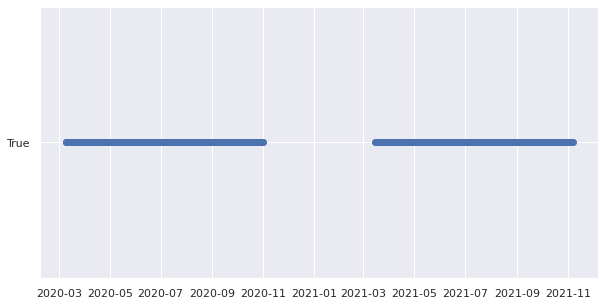

In [497]:
## The MTA information for the date between 2020-11-01 and 2021-03-15 are lost for the stations
## TIMES SQ-42 ST, 42 ST-BRYANT PK and 42 ST-PORT AUTH. 

date = mta[mta.station == '42 ST-PORT AUTH'].date.sort_values().unique()
date_value = []
for key in date:
    date_value.append('True')

## The plot shows the available data for a certain station
plt.figure(figsize=(10,5))
plt.scatter(date,date_value)

## So only GRD CNTRL-42 ST station is selected
mta = mta[mta.station == 'GRD CNTRL-42 ST']

In [498]:
## The entries/exits number is computed by the difference between the register values between a sequential date
mta['entries_num'] = mta.entries - mta.groupby(['station','unit','scp']).entries.shift(1)
mta['exits_num'] = mta.exits - mta.groupby(['station','unit','scp']).exits.shift(1)

In [499]:
## Coarsely check whether there is unreasonable values.
print(mta[mta.station == 'GRD CNTRL-42 ST'].groupby(['unit','scp'])['entries_num'].unique())
print(mta[mta.station == 'GRD CNTRL-42 ST'].groupby(['unit','scp'])['exits_num'].unique())

unit  scp     
R045  00-00-00    [nan, 450.0, 283.0, 1182.0, 942.0, 245.0, 1471...
      00-00-01    [nan, 327.0, 216.0, 887.0, 607.0, 155.0, 1015....
      00-00-02    [nan, 275.0, 206.0, 722.0, 404.0, 99.0, 749.0,...
      00-00-03    [nan, 274.0, 255.0, 444.0, 247.0, 96.0, 346.0,...
      00-00-04    [nan, 287.0, 293.0, 522.0, 320.0, 134.0, 433.0...
                                        ...                        
R048  00-00-00    [nan, 25.0, 3.0, 2474.0, 2237.0, 891.0, 3412.0...
      00-00-01    [nan, 25.0, 4.0, 2484.0, 1986.0, 724.0, 3327.0...
      00-00-02    [nan, 9.0, 0.0, 1887.0, 1523.0, 323.0, 1338.0,...
      00-00-03    [nan, 1.0, 0.0, 1440.0, 1087.0, 215.0, 2073.0,...
      00-00-04    [nan, 2.0, 0.0, 887.0, 500.0, 67.0, 1299.0, 10...
Name: entries_num, Length: 95, dtype: object
unit  scp     
R045  00-00-00    [nan, 1670.0, 1366.0, 3250.0, 1730.0, 587.0, 3...
      00-00-01    [nan, 1334.0, 1297.0, 2161.0, 1206.0, 619.0, 2...
      00-00-02    [nan, 1291.0, 1115.0, 1

In [515]:
## The entries values of some date is smaller than the day before.
print(mta[mta.entries_num < 0][['date','entries','entries_num','exits','exits_num']])

## Those entries counts are set to be zero
mta.entries_num = mta.entries_num.apply(lambda x: 0 if x < 0 else x)
mta.exits_num = mta.exits_num.apply(lambda x: 0 if x < 0 else x)


            date    entries  entries_num      exits  exits_num
49891 2020-11-02      11091   -1046802.0      21131 -2106943.0
83983 2019-12-29  592102622       -928.0  886150392     -731.0
83984 2019-12-30  592101820       -802.0  886149452     -940.0
83985 2019-12-31  592099636      -2184.0  886148014    -1438.0
83986 2020-01-01  592098416      -1220.0  886147354     -660.0
...          ...        ...          ...        ...        ...
43767 2021-03-02       1428      -8383.0        229    -6399.0
2248  2021-11-16        394     -54822.0        243   -43746.0
82707 2020-02-05        188    -306227.0        261  -547050.0
49965 2020-11-02      15443   -8561433.0      11583 -6525914.0
45553 2021-01-28        347   -2844347.0         88 -2837015.0

[451 rows x 5 columns]


,unnamed: 0,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,entries_num,exits_num
81464,81464,R240,R047,00-00-03,GRD CNTRL-42 ST,4567S,IRT,2020-03-08,00:00:00,REGULAR,522075,379077,1450.0,619.0
50055,50055,R240,R047,00-00-03,GRD CNTRL-42 ST,4567S,IRT,2020-11-02,00:00:00,REGULAR,654918,453595,132843.0,74518.0


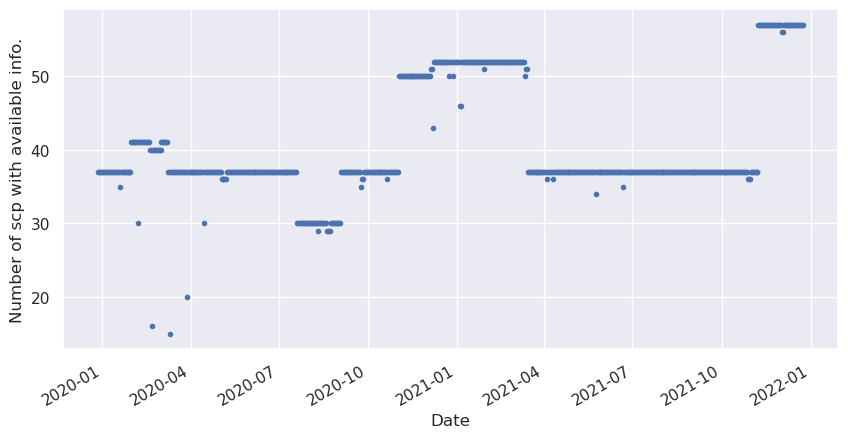

In [558]:
## Some date info are lost for some in station 'GRD CNTRL-42 ST'
# Because the date are not sequential, there might be extremely 
# large value of entries number due to reset or other reason.

datemta = mta.date.unique()
date_unitnum_dict = {}

for i in range(len(datemta)):
    sum_scp = 0
    temp = mta[(mta.date == datemta[i]) & (mta.station == 'GRD CNTRL-42 ST') ].groupby(['unit']).scp.unique()
    for j in range(len(temp)):
        sum_scp += len(temp[j])
    date_unitnum_dict[datemta[i]] = sum_scp

date_unitnum_df = pd.Series(date_unitnum_dict)

plt.figure(figsize=(10,5))
date_unitnum_df.plot(style='.')
plt.xlabel('Date')
plt.ylabel('Number of scp with available info.')

## check entries register value for one of the scp between 2020-03-08 and 2020-11-02
pd.concat([mta[ ((mta.date == '2020-03-08') ) & 
    ((mta.unit == 'R047') & (mta.scp == '00-00-03') & (mta.station == 'GRD CNTRL-42 ST'))],
         mta[ ((mta.date == '2020-11-02') ) & 
    ((mta.unit == 'R047') & (mta.scp == '00-00-03') & (mta.station == 'GRD CNTRL-42 ST'))]],axis = 0)

In [536]:
## merge the weather info and covid info with mta data
dfgroupdate = pd.merge(pd.merge(mta,cnc,on='date'),wt,on='date').groupby('date')
dffinal = pd.concat([dfgroupdate.entries_num.sum(),dfgroupdate.exits_num.sum(), dfgroupdate.tmax.mean(), dfgroupdate.tmin.mean(),
                    dfgroupdate.prcp.mean(),dfgroupdate.cases.mean()], axis=1)

# There is not a systematic way to deal with those off-normal date due to lost date.
# So I directly truncate the entries and exits value, and also the date.
dffinal = dffinal[dffinal.entries_num<2e4]
dffinal = dffinal[dffinal.exits_num<2e4]
dffinal = dffinal[dffinal.index > '2020-03-15']
dffinal.sort_values('date').head()

,entries_num,exits_num,tmax,tmin,prcp,cases
date,,,,,,
2020-03-16,7436.0,7441.0,7.2,0.6,0.0,464.0
2020-03-17,17842.0,19009.0,12.2,5.0,4.1,646.0
2020-03-18,13741.0,14774.0,12.2,5.0,0.0,1344.0
2020-03-19,11580.0,12808.0,11.1,5.0,23.6,2477.0
2020-03-20,10125.0,11215.0,25.0,8.3,0.0,4419.0


In [571]:
## create column with day of week 
dffinal['dayofweek'] = dffinal.index.dayofweek
dffinal.head()

,entries_num,exits_num,tmax,tmin,prcp,cases,dayofweek
date,,,,,,,
2020-03-16,7436.0,7441.0,7.2,0.6,0.0,464.0,0
2020-03-17,17842.0,19009.0,12.2,5.0,4.1,646.0,1
2020-03-18,13741.0,14774.0,12.2,5.0,0.0,1344.0,2
2020-03-19,11580.0,12808.0,11.1,5.0,23.6,2477.0,3
2020-03-20,10125.0,11215.0,25.0,8.3,0.0,4419.0,4


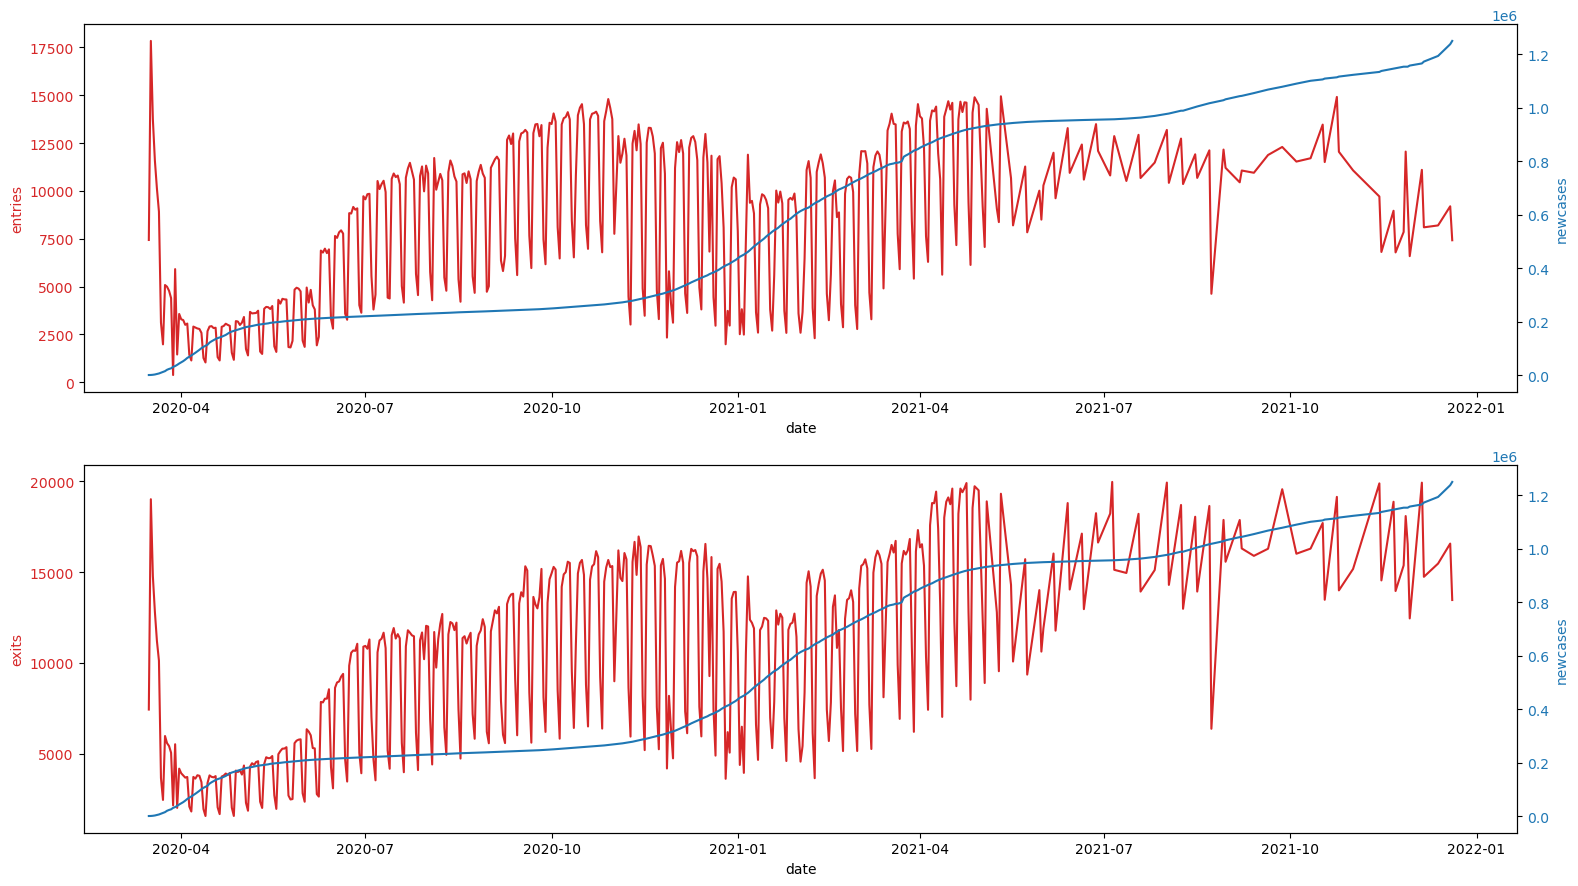

In [572]:
## Time trend of entries/exits and Covid new cases
mpl.rc_file_defaults()
fig, ax1 = plt.subplots(2)

color = 'tab:red'
ax1[0].set_xlabel('date')
ax1[0].set_ylabel('entries', color=color)
ax1[0].plot(dffinal.index, dffinal.entries_num, color=color)
ax1[0].tick_params(axis='y', labelcolor=color)

ax2 = ax1[0].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('newcases', color=color)  # we already handled the x-label with ax1
ax2.plot(dffinal.index, dffinal.cases, color=color)
ax2.tick_params(axis='y', labelcolor=color)

###################################
color = 'tab:red'
ax1[1].set_xlabel('date')
ax1[1].set_ylabel('exits', color=color)
ax1[1].plot(dffinal.index, dffinal.exits_num, color=color)
ax1[1].tick_params(axis='y', labelcolor=color)

ax2 = ax1[1].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('newcases', color=color)  # we already handled the x-label with ax1
ax2.plot(dffinal.index, dffinal.cases, color=color)
ax2.tick_params(axis='y', labelcolor=color)

#####################################

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.set_size_inches(18.5, 10.5, forward=True)
plt.rc('font', size=15) 
plt.show()

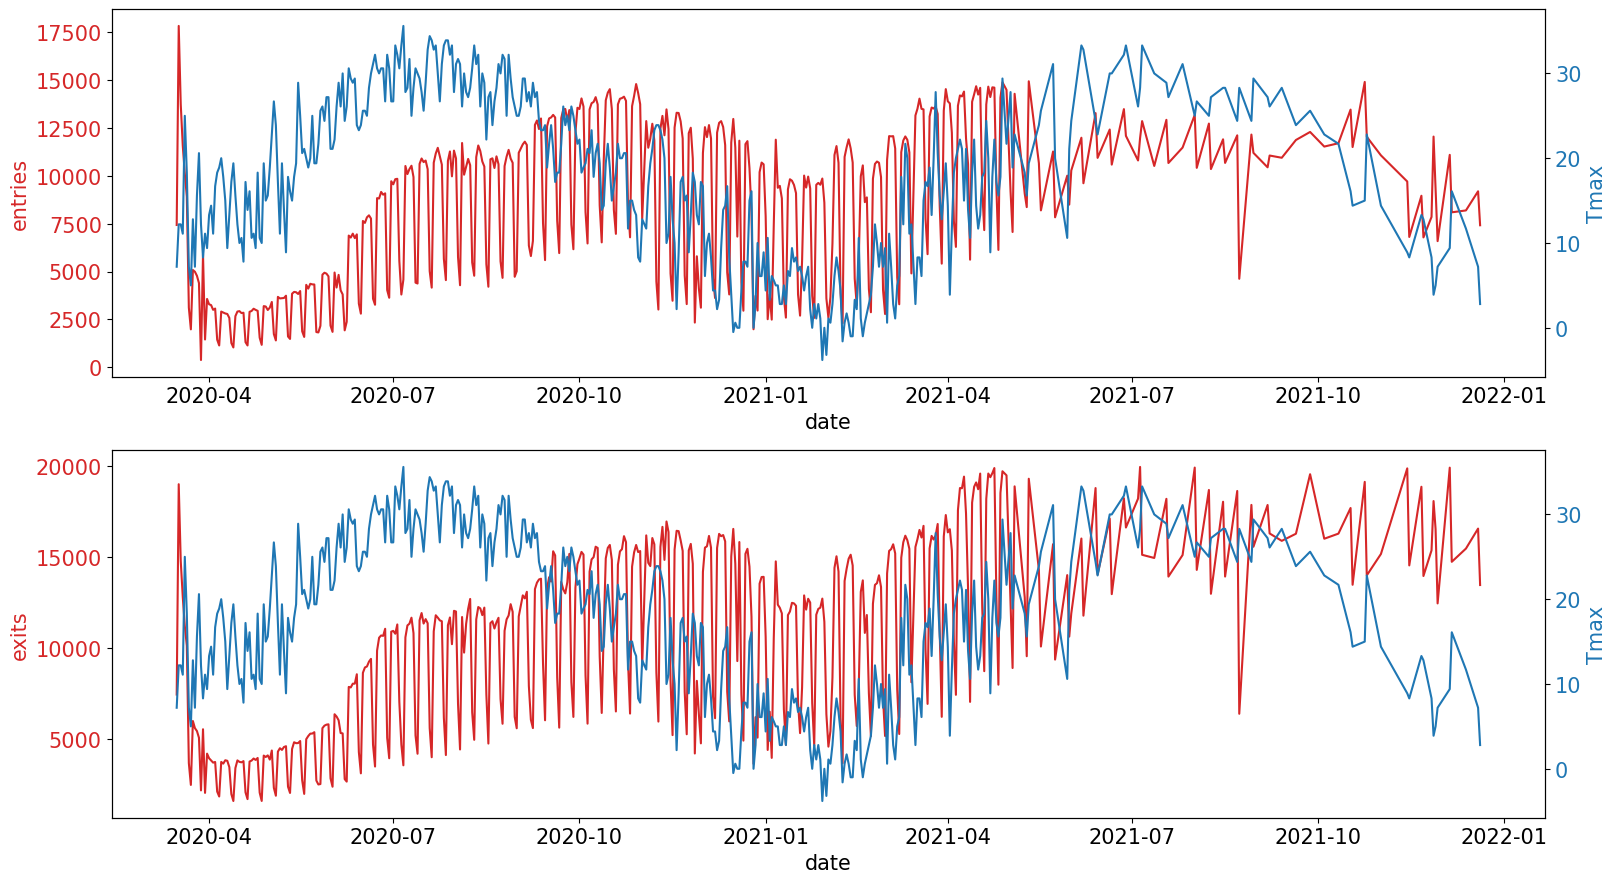

In [573]:
## Time trend of entries/exits and max temperature
fig, ax1 = plt.subplots(2)

###################################
color = 'tab:red'
ax1[0].set_xlabel('date')
ax1[0].set_ylabel('entries', color=color)
ax1[0].plot(dffinal.index, dffinal.entries_num, color=color)
ax1[0].tick_params(axis='y', labelcolor=color)

ax2 = ax1[0].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Tmax', color=color)  # we already handled the x-label with ax1
ax2.plot(dffinal.index, dffinal.tmax, color=color)
ax2.tick_params(axis='y', labelcolor=color)

###################################
color = 'tab:red'
ax1[1].set_xlabel('date')
ax1[1].set_ylabel('exits', color=color)
ax1[1].plot(dffinal.index, dffinal.exits_num, color=color)
ax1[1].tick_params(axis='y', labelcolor=color)

ax2 = ax1[1].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Tmax', color=color)  # we already handled the x-label with ax1
ax2.plot(dffinal.index, dffinal.tmax, color=color)
ax2.tick_params(axis='y', labelcolor=color)

#####################################

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.set_size_inches(18.5, 10.5, forward=True)
plt.rc('font', size=15) 
plt.show()

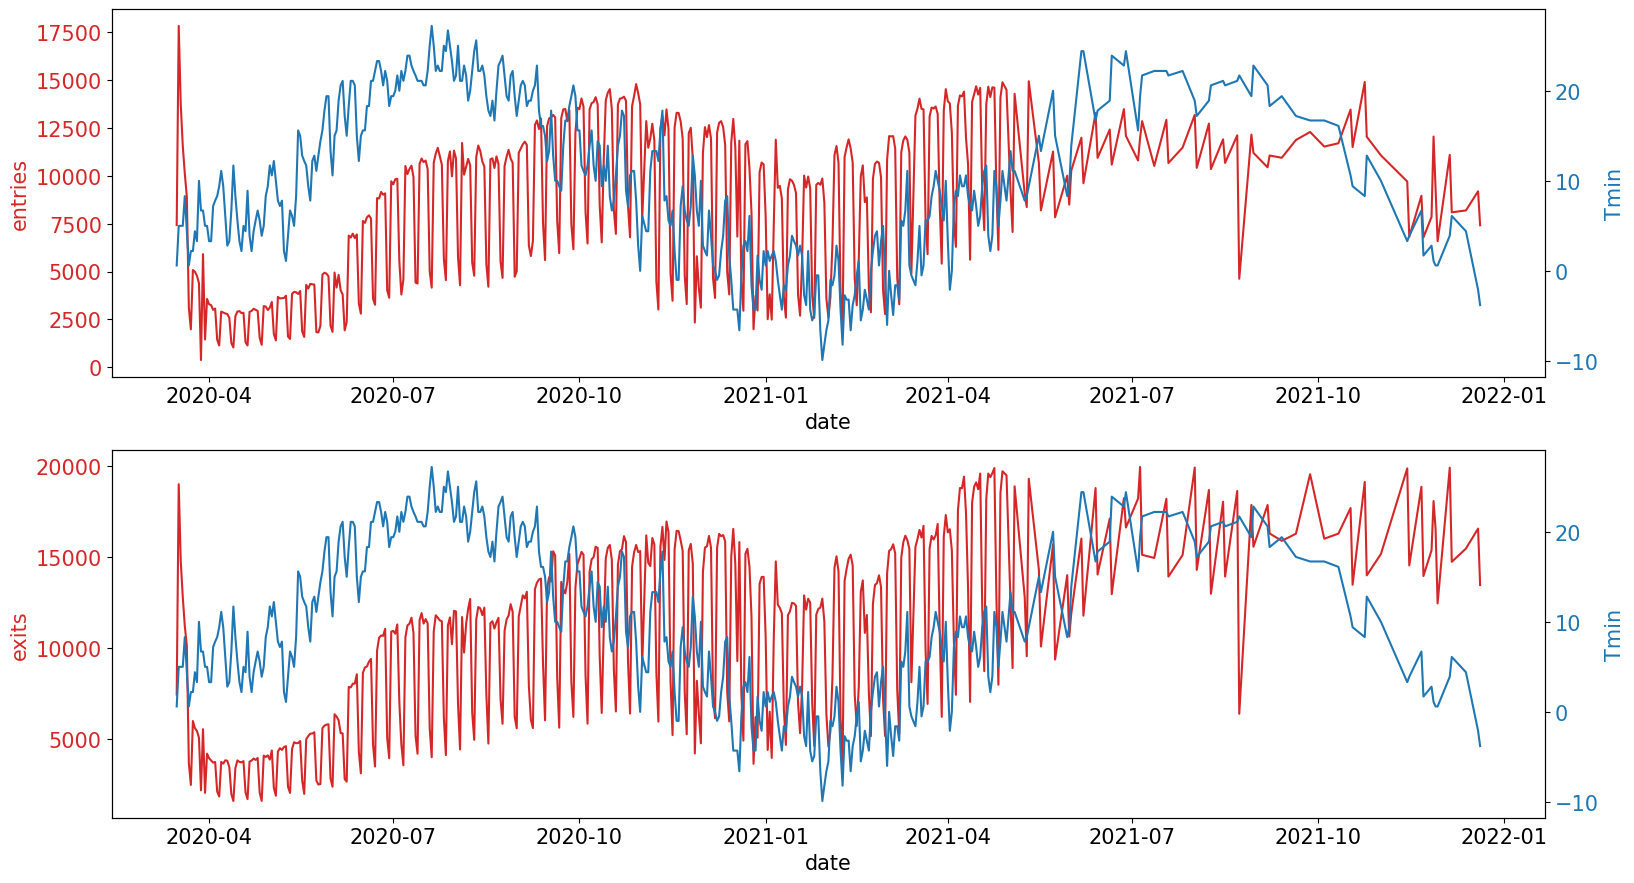

In [574]:
## Time trend of entries/exits and min temperature

fig, ax1 = plt.subplots(2)

###################################
color = 'tab:red'
ax1[0].set_xlabel('date')
ax1[0].set_ylabel('entries', color=color)
ax1[0].plot(dffinal.index, dffinal.entries_num, color=color)
ax1[0].tick_params(axis='y', labelcolor=color)

ax2 = ax1[0].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Tmin', color=color)  # we already handled the x-label with ax1
ax2.plot(dffinal.index, dffinal.tmin, color=color)
ax2.tick_params(axis='y', labelcolor=color)

###################################
color = 'tab:red'
ax1[1].set_xlabel('date')
ax1[1].set_ylabel('exits', color=color)
ax1[1].plot(dffinal.index, dffinal.exits_num, color=color)
ax1[1].tick_params(axis='y', labelcolor=color)

ax2 = ax1[1].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Tmin', color=color)  # we already handled the x-label with ax1
ax2.plot(dffinal.index, dffinal.tmin, color=color)
ax2.tick_params(axis='y', labelcolor=color)

#####################################

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.set_size_inches(18.5, 10.5, forward=True)
plt.rc('font', size=15) 
plt.show()

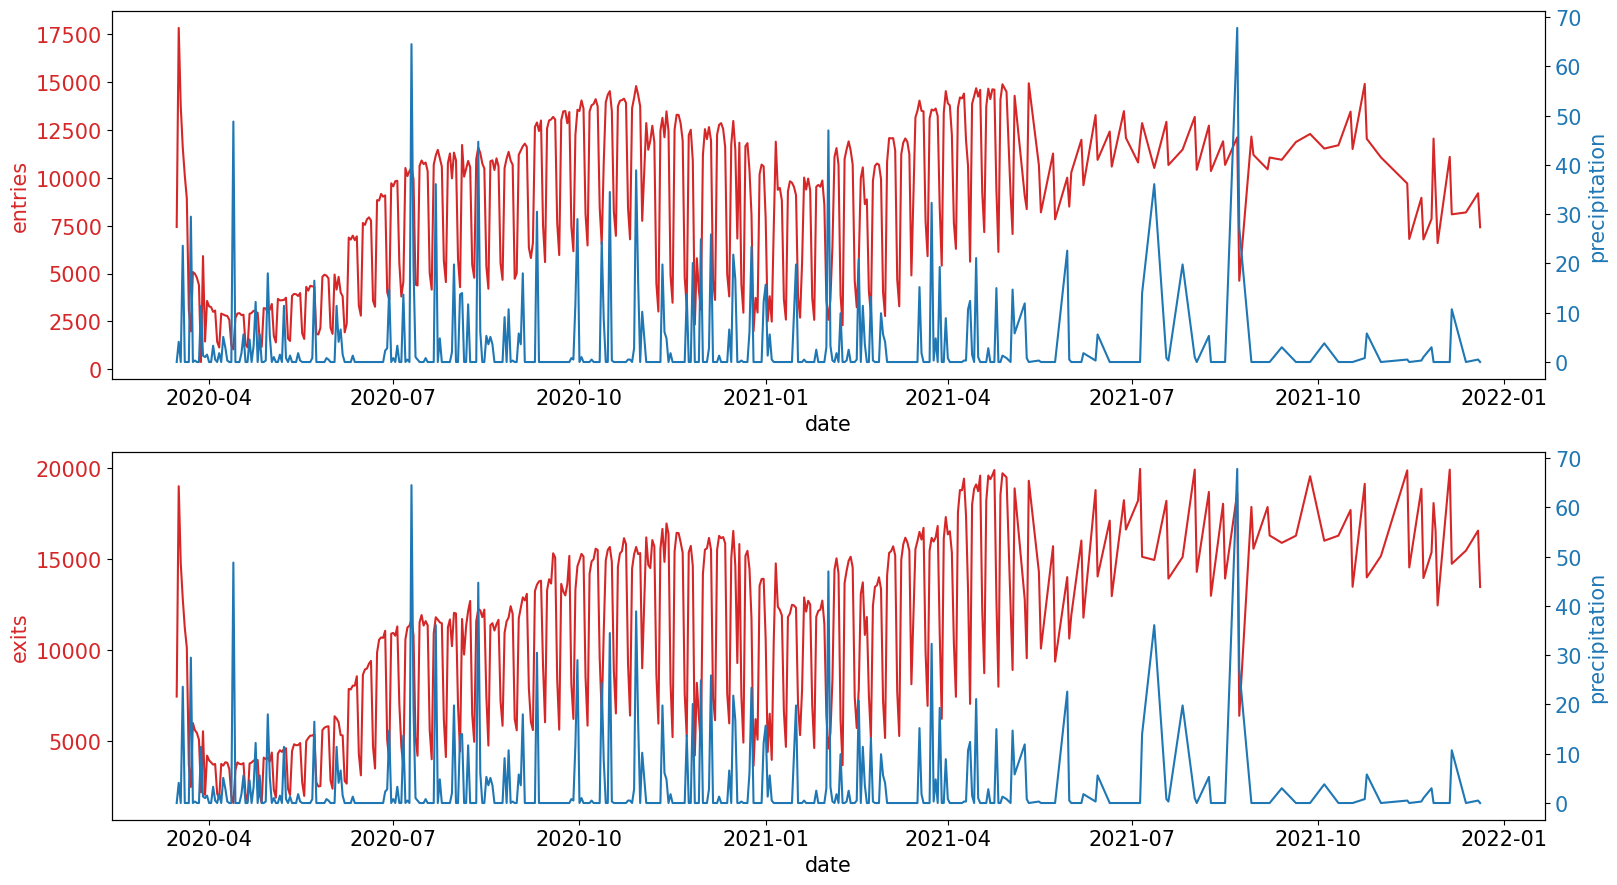

In [575]:
## Time trend of entries/exits and precipitation

fig, ax1 = plt.subplots(2)

###################################
color = 'tab:red'
ax1[0].set_xlabel('date')
ax1[0].set_ylabel('entries', color=color)
ax1[0].plot(dffinal.index, dffinal.entries_num, color=color)
ax1[0].tick_params(axis='y', labelcolor=color)

ax2 = ax1[0].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('precipitation', color=color)  # we already handled the x-label with ax1
ax2.plot(dffinal.index, dffinal.prcp, color=color)
ax2.tick_params(axis='y', labelcolor=color)

###################################
color = 'tab:red'
ax1[1].set_xlabel('date')
ax1[1].set_ylabel('exits', color=color)
ax1[1].plot(dffinal.index, dffinal.exits_num, color=color)
ax1[1].tick_params(axis='y', labelcolor=color)

ax2 = ax1[1].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('precipitation', color=color)  # we already handled the x-label with ax1
ax2.plot(dffinal.index, dffinal.prcp, color=color)
ax2.tick_params(axis='y', labelcolor=color)

#####################################

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.set_size_inches(18.5, 10.5, forward=True)
plt.rc('font', size=15) 
plt.show()

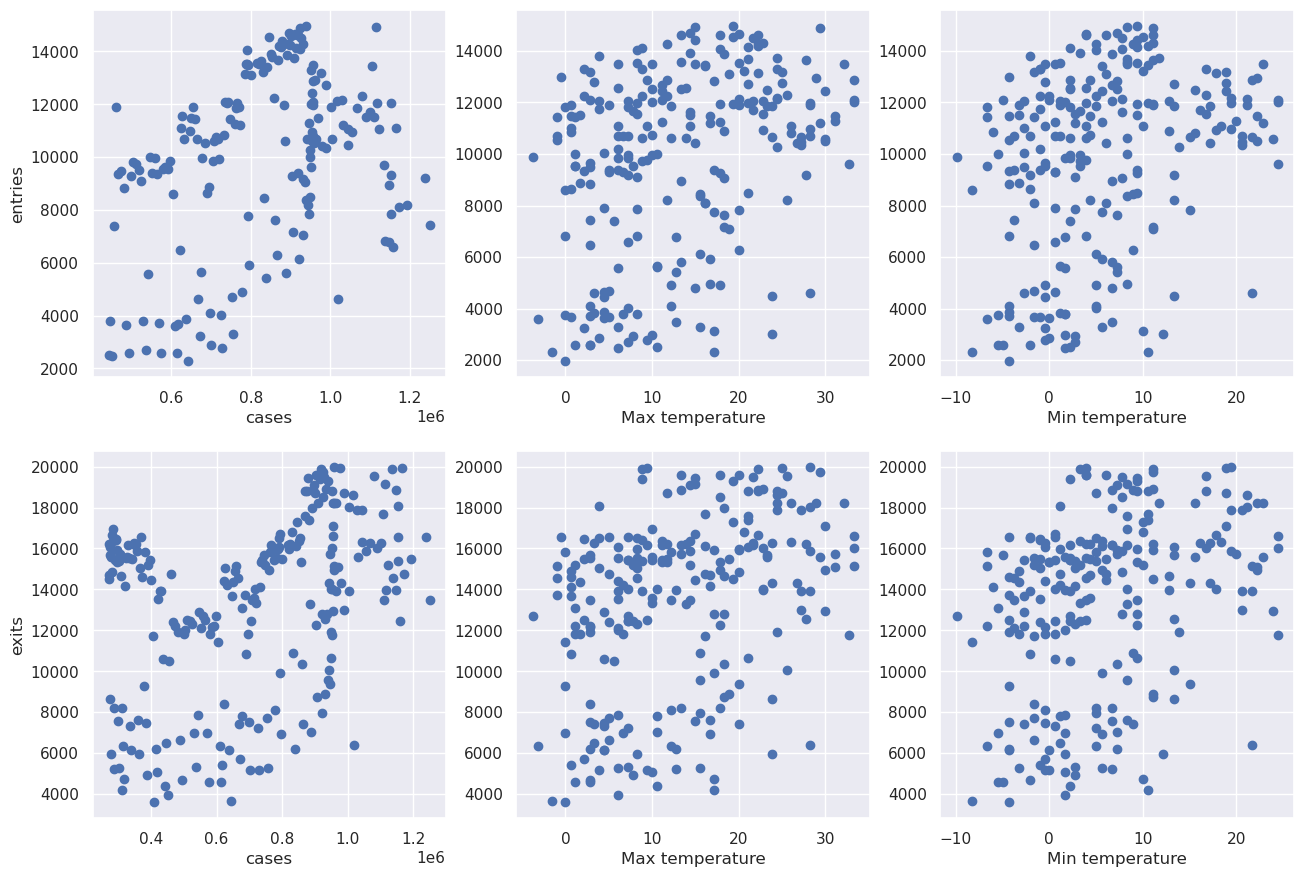

In [581]:
## The first row: entries as response to covid cases, max/min temperature
## The second row: exits as response to covid cases, max/min temperature

fig,ax = plt.subplots(2,3)#plt.subplots(nrows=2, ncols=2)
sns.set_theme()


dfplot = dffinal[dffinal.index > '2020-11-02']
ax[0][0].set_xlabel('cases')
ax[0][0].set_ylabel('entries')
ax[0][0].scatter(dfplot.cases,dfplot.entries_num)

ax[0][1].set_xlabel('Max temperature')
# ax[0][1].get_yaxis().set_visible(False)
# ax[0][1].set_ylabel('entries')
ax[0][1].scatter(dfplot.tmax,dfplot.entries_num)

ax[0][2].set_xlabel('Min temperature')
# ax[0][2].get_yaxis().set_visible(False)
# ax[0][2].set_ylabel('entries')
ax[0][2].scatter(dfplot.tmin,dfplot.entries_num)


######################################
ax[1][0].set_xlabel('cases')
ax[1][0].set_ylabel('exits')
ax[1][0].scatter(dfplot.cases,dfplot.exits_num)

ax[1][1].set_xlabel('Max temperature')
# ax[1][1].get_yaxis().set_visible(False)
# ax[1][1].set_ylabel('entries')
ax[1][1].scatter(dfplot.tmax,dfplot.exits_num)

ax[1][2].set_xlabel('Min temperature')
# ax[1][2].get_yaxis().set_visible(False)
# ax[1][2].set_ylabel('entries')
ax[1][2].scatter(dfplot.tmin,dfplot.exits_num)

# fig.tight_layout()
fig.set_size_inches(15.5, 10.5, forward=True)
plt.rc('font', size=15) 
plt.show()

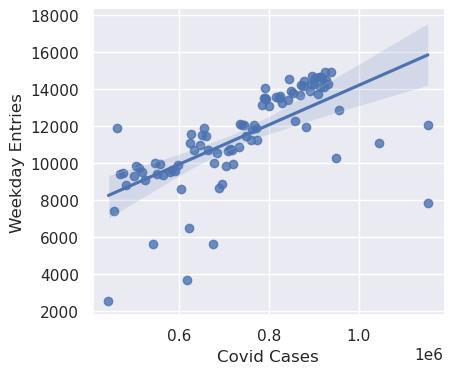

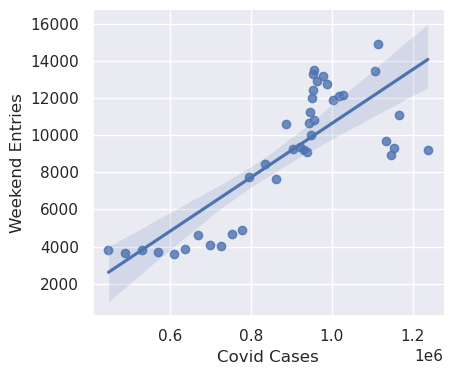

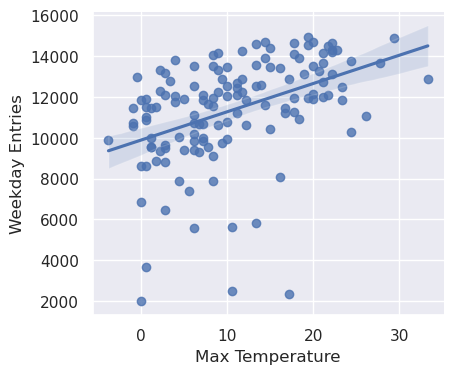

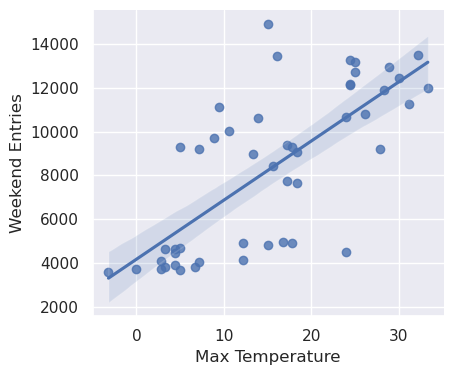

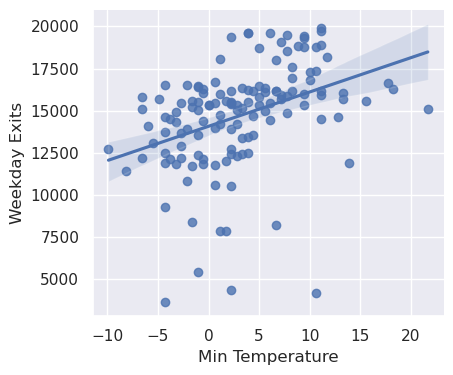

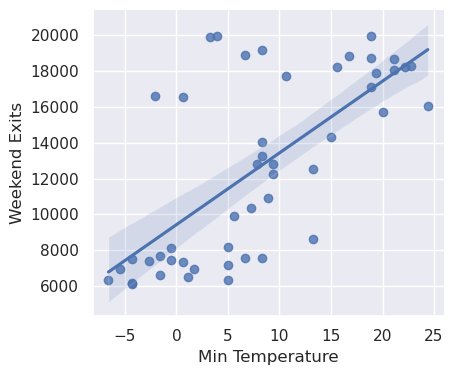

In [582]:
## The same plots but made by seaborn, with regression line.

h = 4
asp = 1.2

dfplot = dffinal[dffinal.index > '2021-01-01']
dfweekday = dfplot[(dfplot.dayofweek >= 1) & (dfplot.dayofweek <= 5)]
dfweekend = dfplot[(dfplot.dayofweek == 6) | (dfplot.dayofweek == 7)]

##################################
g = sns.lmplot(x='cases',y='entries_num',data=dfweekday,fit_reg=True,height=h, aspect=asp)
g.set_axis_labels("Covid Cases", "Weekday Entries")

g = sns.lmplot(x='cases',y='entries_num',data=dfweekend,fit_reg=True,height=h, aspect=asp)
g.set_axis_labels("Covid Cases", "Weekend Entries")

dfplot = dffinal[dffinal.index > '2020-11-01']
dfweekday = dfplot[(dfplot.dayofweek >= 1) & (dfplot.dayofweek <= 5)]
dfweekend = dfplot[(dfplot.dayofweek == 6) | (dfplot.dayofweek == 7)]
##################################
g = sns.lmplot(x='tmax',y='entries_num',data=dfweekday,fit_reg=True,height=h, aspect=asp)
g.set_axis_labels("Max Temperature", "Weekday Entries")

g = sns.lmplot(x='tmax',y='entries_num',data=dfweekend,fit_reg=True,height=h, aspect=asp)
g.set_axis_labels("Max Temperature", "Weekend Entries")
##################################

g = sns.lmplot(x='tmin',y='exits_num',data=dfweekday,fit_reg=True,height=h, aspect=asp)
g.set_axis_labels("Min Temperature", "Weekday Exits")

g = sns.lmplot(x='tmin',y='exits_num',data=dfweekend,fit_reg=True,height=h, aspect=asp)
g.set_axis_labels("Min Temperature", "Weekend Exits")



In [579]:
## extract the information for different level of precipitation

crit_heavy_prcp = [10,50]
crit_mod_prcp = [2.5,10]
crit_light_prcp = [0,2.5]

dfweekday = dfplot[(dfplot.dayofweek >= 1) & (dfplot.dayofweek <= 5)]

df_heavyrain = dfweekday[(dfweekday.prcp>crit_heavy_prcp[0])&(dfweekday.prcp<crit_heavy_prcp[1])]
df_modrain = dfweekday[(dfweekday.prcp>crit_mod_prcp[0])&(dfweekday.prcp<crit_mod_prcp[1])]
df_lightrain = dfweekday[(dfweekday.prcp>crit_light_prcp[0])&(dfweekday.prcp<crit_light_prcp[1])]

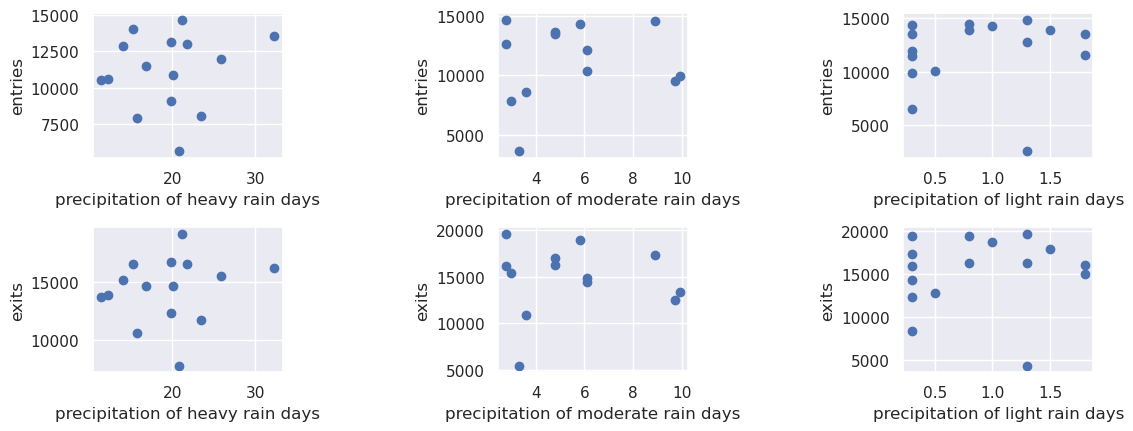

In [580]:
## The first row: entries as response to heavy,moderate,light rain
## The second row: exits as response to heavy,moderate,light rain
fig,ax = plt.subplots(2,3)

ax[0][0].set_xlabel('precipitation of heavy rain days')
ax[0][0].set_ylabel('entries')
# ax[0][0].get_xaxis().set_visible(False)
ax[0][0].scatter(df_heavyrain.prcp,df_heavyrain.entries_num)

ax[0][1].set_xlabel('precipitation of moderate rain days')
ax[0][1].set_ylabel('entries')
# ax[0][1].get_xaxis().set_visible(False)
# ax[0][1].get_yaxis().set_visible(False)
ax[0][1].scatter(df_modrain.prcp,df_modrain.entries_num)

ax[0][2].set_xlabel('precipitation of light rain days')
ax[0][2].set_ylabel('entries')
# ax[0][2].get_xaxis().set_visible(False)
# ax[0][2].get_yaxis().set_visible(False)
ax[0][2].scatter(df_lightrain.prcp,df_lightrain.entries_num)


ax[1][0].set_xlabel('precipitation of heavy rain days')
ax[1][0].set_ylabel('exits')
ax[1][0].scatter(df_heavyrain.prcp,df_heavyrain.exits_num)

ax[1][1].set_xlabel('precipitation of moderate rain days')
ax[1][1].set_ylabel('exits')
# ax[1][1].get_xaxis().set_visible(False)
# ax[1][1].get_yaxis().set_visible(False)
ax[1][1].scatter(df_modrain.prcp,df_modrain.exits_num)

ax[1][2].set_xlabel('precipitation of light rain days')
ax[1][2].set_ylabel('exits')
# ax[1][2].get_xaxis().set_visible(False)
# ax[1][2].get_yaxis().set_visible(False)
ax[1][2].scatter(df_lightrain.prcp,df_lightrain.exits_num)

fig.tight_layout()
fig.set_size_inches(12.5, 4.5, forward=True)
plt.rc('font', size=15) 
plt.show()

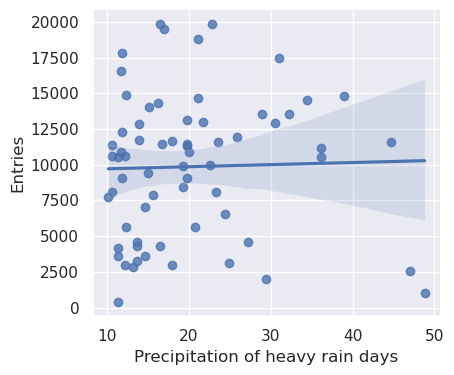

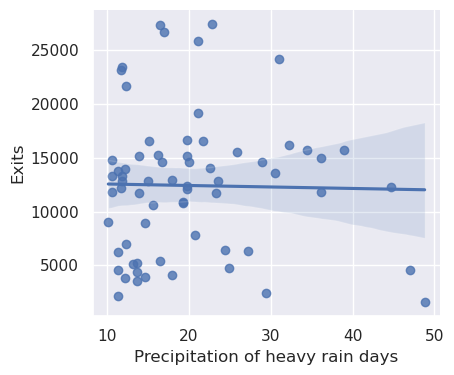

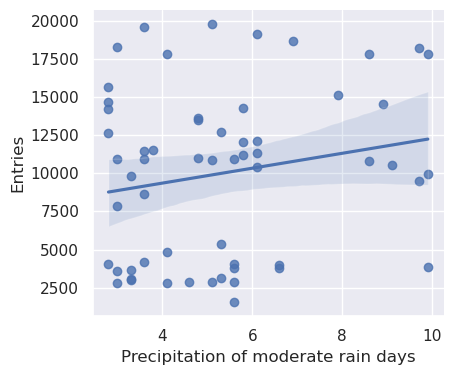

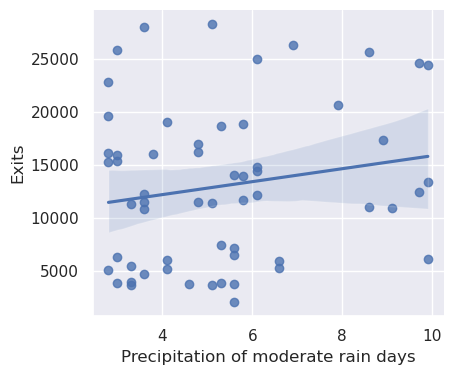

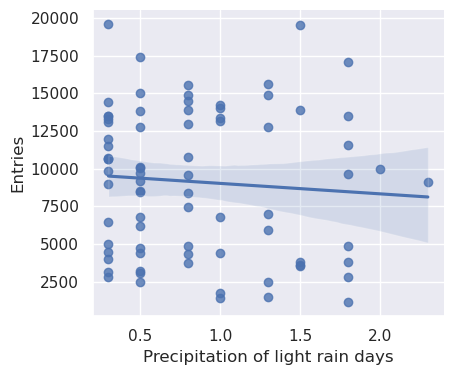

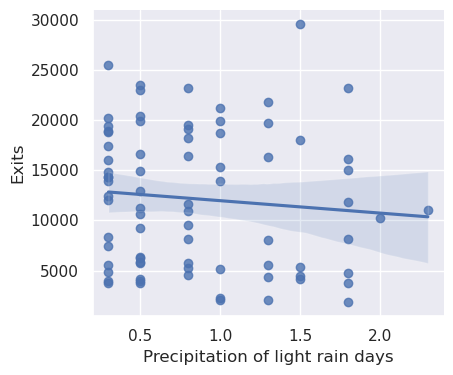

In [565]:
# Same plots made with seaborn

h = 4
asp = 1.2

##################################
g = sns.lmplot(x='prcp',y='entries_num',data=prcp_heavyrain,fit_reg=True,height=h, aspect=asp)
g.set_axis_labels("Precipitation of heavy rain days", "Entries")

g = sns.lmplot(x='prcp',y='exits_num',data=prcp_heavyrain,fit_reg=True,height=h, aspect=asp)
g.set_axis_labels("Precipitation of heavy rain days", "Exits")

##################################
g = sns.lmplot(x='prcp',y='entries_num',data=prcp_modrain,fit_reg=True,height=h, aspect=asp)
g.set_axis_labels("Precipitation of moderate rain days", "Entries")

g = sns.lmplot(x='prcp',y='exits_num',data=prcp_modrain,fit_reg=True,height=h, aspect=asp)
g.set_axis_labels("Precipitation of moderate rain days", "Exits")

##################################
g = sns.lmplot(x='prcp',y='entries_num',data=prcp_lightrain,fit_reg=True,height=h, aspect=asp)
g.set_axis_labels("Precipitation of light rain days", "Entries")

g = sns.lmplot(x='prcp',y='exits_num',data=prcp_lightrain,fit_reg=True,height=h, aspect=asp)
g.set_axis_labels("Precipitation of light rain days", "Exits")